# TFY4345 Computational Assignment 1
# Projectile Motion

In this project we will implement a numerical method to calculate a projectile trajectory. We are using Runge-Kutta's method of 4th order, defined on the form:
$$ F_1 = F(y_n) $$
$$ F_2 = F(y_n+\tfrac12hF_1) $$
$$ F_3 = F(y_n+\tfrac12hF_2) $$
$$ F_4 = F(y_n+hF_3) $$
$$ y_{n+1} = y_n + h(\tfrac16F_1+\tfrac13F_2+\tfrac13F_3+\tfrac16F_4)$$

When the y-position reaches zero, we want to stop the calculation. To estimate the x-position where y=0, we use linear interpolation as given in the assignment description:

$$ x_l = \frac{x_n+rx_{n+1}}{r+1}, $$

where $$r=-\frac{y_n}{y_{n+1}}.$$

Furthermore we will expand our model to take into considerations the air resistance. We will be using two different models for air density: A model where we treat the atmosphere as an isothermal ideal gas and an adiabatic approximation. The equations we have used in the code, is taken from the assignment description. 

In [5]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

#Here are the code that defines the system, with constants and classes. 


#Constants and parameters:

v_0 = 700  # firing velocity in m/s
theta = 30  # firing angle in degrees

a = 6.5e-3  # constant in adiabatic approximation?
T0 = 288
y_0 = 1e4  # k_B*T/mg
alfa = 2.5  # constant for air
drag_coefficient = 4e-5  # per air particle mass, in m^-1#!/usr/bin/python
g = 9.81

y0 = 1e4

from typing import Callable, Tuple, NamedTuple, Union, List

def RK4(f: Callable[[any,float], float], y: any, t: float, dt: float) -> Tuple[any, float]:
	k_1 = f(y, t)
	k_2 = f(y+k_1*dt/2, t+dt/2)
	k_3 = f(y+k_2*dt/2, t+dt/2)
	k_4 = f(y+k_3*dt, t+dt)
	y_next = y + 1/6*(k_1+2*k_2+2*k_3+k_4)*dt
	return y_next, t+dt


def Euler(f: Callable[[any, float], float], y:any, t:float, dt:float) -> Tuple[any, float]:
	k_1 = f(y, t)
	y_next = y + k_1*dt
	return y_next, t+dt


def crossing(ph_1: Phase, ph_2: Phase, y_crossing: float) -> Union[float, bool]:
	if not ((ph_1.y < y_crossing) ^ (ph_2.y < y_crossing)):
		return False
	r = -ph_1.y/ph_2.y
	return (r*ph_2.x + ph_1.x)/(r+1)


class Phase(NamedTuple):
	x: float
	y: float
	v_x: float
	v_y: float

	def speed(self):
		return np.sqrt(self.v_x**2+self.v_y**2)

	def __add__(self, rhs: Phase):
		return Phase(*[l+r for l,r in zip(self, rhs)])

	def __radd__(self, lhs: Phase):
		return self + lhs

	def __mul__(self, rhs:float):
		return Phase(*[l*rhs for l in self])

	def __rmul__(self, lhs:float):
		return self*lhs

	def __truediv__(self, rhs:float):
		return self*(1/rhs)


class Drag_type(Enum):
	NODRAG = "No drag"
	UNIFORM = "Uniform drag"
	ISOTHERMAL = "Isothermal drag"
	ADIABATIC = "Adiabatic drag"



def phase_derivative_nodrag(ph: Phase, t: float):
	'''Basic derivative-equation'''
	return Phase(ph.v_x, ph.v_y, 0, -g)

def phase_derivative_drag(ph: Phase, t: float, drag_multiplier=1):
	'''Derivative-equation including drag'''
	#Friction points in negative-v-direction with size B*v^2, where
	# B/m = drag_coefficient, so the acceleration caused
	#  by friction is given by drag_coefficient * v * (-v-vector)
	drag_factor = drag_coefficient*ph.speed()*drag_multiplier  #
	return Phase(ph.v_x, ph.v_y, -drag_factor*ph.v_x, -drag_factor*ph.v_y-g)

def phase_derivative_isothermal_drag(ph: Phase, t: float):
	drag_multiplier = np.exp(-ph.y/y0)
	return phase_derivative_drag(ph, t, drag_multiplier)

def phase_derivative_uniform_drag(ph: Phase, t: float):
	return phase_derivative_drag(ph, t)

def phase_derivative_adiabatic_drag(ph: Phase, t: float):
	drag_multiplier = (1-6.5e-3*ph.y/T0)**alfa
	return phase_derivative_drag(ph, t, drag_multiplier)

def phase_prime_method(drag_type:Drag_type=Drag_type.NODRAG):
	if drag_type is Drag_type.NODRAG: return phase_derivative_nodrag
	elif drag_type is Drag_type.UNIFORM: return phase_derivative_uniform_drag
	elif drag_type is Drag_type.ISOTHERMAL: return phase_derivative_isothermal_drag
	elif drag_type is Drag_type.ADIABATIC: return phase_derivative_adiabatic_drag
	else:
		raise Exception("How did you get here?")


class SYS:
	phases: List[Phase]
	crash_distance: Union[None, float]
	def __init__(self, init_phase:Phase, init_time:float=0,
				 drag_type:Drag_type=Drag_type.NODRAG):
		self.phases = [init_phase]
		self.times = [init_time]
		self.crash_distance = None

		self.prop_method = phase_prime_method(drag_type)

	def propagate_until_crash(self, y_floor:float, dt=1):
		while True:
			current_phase = self.phases[-1]
			t = self.times[-1]
			next_phase, t_next = RK4(self.prop_method, current_phase, t, dt)
			if (x_cross := crossing(current_phase, next_phase, y_floor)) is False:
				self.phases.append(next_phase)
				self.times.append(t_next)
				continue
			self.crash_distance = x_cross
			break


def polar_to_cartesian(abs_val: float, theta: float):
	return abs_val*np.cos(theta), abs_val*np.sin(theta)

## Task 1: Projectile motion with air resistance
a) Using fire angle $\theta = 45^\circ$ and a fire velocity of $v_0 = 700 m/s$, we can plot the projectile motion without drag.

We also want to solve the equationset:
$$\frac{d^2x}{dt^2}=0$$
$$\frac{d^2y}{dt^2}=-g,$$

to get an analytical answer. This gives:
$$x=v_x\cdot\Delta t$$
$$y=v_y\cdot\Delta t -\frac12g\Delta t^2,$$

where we have

$$v_x=v_0\cdot cos\theta$$
$$v_y=v_0\cdot sin\theta.$$

Setting the equation for y equal to zero, we get that the projectile reaches the ground at $t=100.912s$, which gives $x \approx 49949.03 m$. Our numerical solution with timestep $\Delta t=0.1$ gives $x\approx 49949.03$, which is a very good solution compared to our analytical result. Smaller timesteps would naturally give an even more accurate solution, and we have checked for $\Delta t=1$, $\Delta t=0.1$ and $\Delta t=0.001$, to see that the numerical solution converges to the analytical.

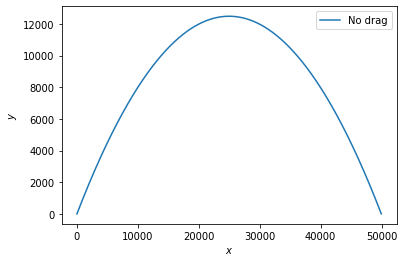

The projectile range is 49949.03


In [10]:
v = 700
fig, ax = plt.subplots(1,1)
initial_phase = Phase(0, 0, *polar_to_cartesian(v, np.pi/4))
launch = SYS(initial_phase, drag_type=Drag_type.NODRAG)
launch.propagate_until_crash(y_floor=0, dt=1e-1)
phases = launch.phases
xs, ys, vxs, vys = np.array(phases).T
ax.plot(xs, ys, label="No drag")
ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.show()

print(f"The projectile range is {launch.crash_distance:.7g}")

b) Here we will plot the projectile motion with drag for three different models.

I) Without any air density corrections  
II) With the isothermic density model  
III) With the adiabatic density model

To determine the optimal value of the angle that gives the maximum range, we check for different thetas and see which value gives the best range. 

## Task 2: The Paris gun

Here we are using a firing velocity of 1640 m/s, and a shell of 160 kg. We are using the adiabatic air density model and the same parameters as task 1. 